In [1]:
# Predict Success or Failure of starups
# 1. funding analysis
# 2. acquisition analysis
# 3. factor analysis
# 3.1 member
# 3.2 investor analysis
# 3.3 keyword analysis

In [2]:
import pandas as pd
import re
import gensim
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
df_people = pd.read_csv(data_folder + 'people.csv')
df_degrees = pd.read_csv(data_folder + 'degrees.csv')

In [4]:
# Predict Success or Failure of starups
# 1. funding analysis

# 특정 기간 뒤에 만드러진 스타트업에 대해, 투자의 분포를 측정한다
def plot_funding_after(founded_after_this):
    df_organizations['founded_on'] = pd.to_datetime(df_organizations['founded_on'], errors='ignore')
    companies = df_organizations[df_organizations['founded_on'] >= founded_after_this]['uuid']
    print('There are {} companies founded after {}'.format(len(companies), founded_after_this))
    fundings = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies)]
    fig, axs = plt.subplots(2,1, figsize=(10, 10))

    # 투자 종류별 투자 횟수
    print(fundings.groupby(fundings['funding_round_type'])['raised_amount_usd'].count()).nlargest(20).reset_index()
    
    # 시리즈 별 투자 횟수
    fundings.groupby(fundings['funding_round_code'])['raised_amount_usd'].count().plot(kind = 'bar', ax = axs[0])
    print(fundings.groupby(fundings['funding_round_code'])['raised_amount_usd'].count())
    
    # 시리즈 별 평균 투자 금액
    fundings.groupby(fundings['funding_round_code'])['raised_amount_usd'].mean().plot(kind = 'bar', ax = axs[1])
    print(fundings.groupby(fundings['funding_round_code'])['raised_amount_usd'].mean())

There are 181768 companies founded after 2010-01-01
       funding_round_type  raised_amount_usd
0                    seed              29387
1                 venture              20835
2                   angel               5071
3          debt_financing               2638
4        convertible_note               2423
5                   grant               2145
6     equity_crowdfunding               1283
7             undisclosed                865
8    product_crowdfunding                515
9          private_equity                411
10        post_ipo_equity                210
11  non_equity_assistance                193
12          post_ipo_debt                 40
13       secondary_market                 12
funding_round_code
A    8247
B    3267
C    1052
D     306
E      78
F      21
G       5
H       1
Name: raised_amount_usd, dtype: int64
funding_round_code
A    8.366202e+06
B    2.055904e+07
C    3.855064e+07
D    8.136001e+07
E    1.426241e+08
F    3.404938e+08
G    2.19

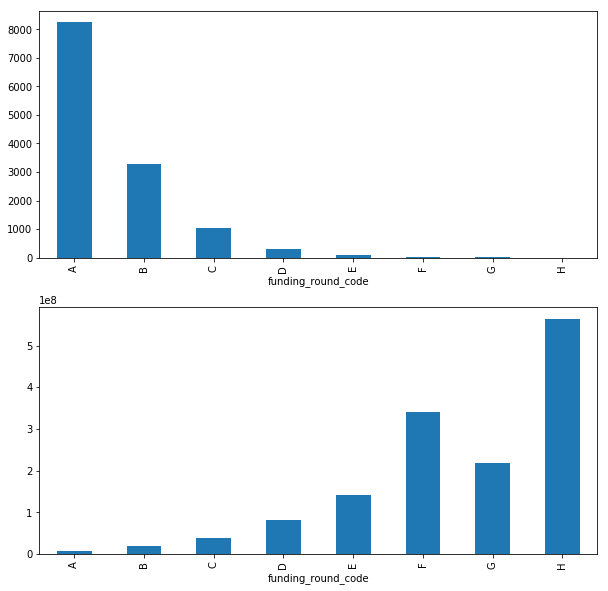

In [5]:
plot_funding_after('2010-01-01')

In [6]:
# Predict Success or Failure of starups
# 3. factor analysis,  성공한 스타트업의 주요 요소 분석

# 데이터 전처리

print('total acquisition:', df_acq.shape[0])
# limiting to acqusition greater than 1M
df_acq = df_acq[df_acq['price_usd'] > 1000000]
print('acquisition 1M+:', df_acq.shape[0])
print('acqusition 1M ~ 10M', df_acq[df_acq['price_usd'] < 10000000].shape[0])
print('acqusition 1M ~ 50M', df_acq[df_acq['price_usd'] < 50000000].shape[0])

('total acquisition:', 47412)
('acquisition 1M+:', 9467)
('acqusition 1M ~ 10M', 1084)
('acqusition 1M ~ 50M', 3388)


In [7]:
# Predict Success or Failure of starups
# 3. factor analysis,  성공한 스타트업의 주요 요소 분석

# 데이터 전처리
# 학벌을 분석하기 위하여 가장 만이 쓰이는 100개의 학위를 확인하고 수작업으로 다음과 같이 분리

# 수작업으로 데이터 확인
# print df_degrees.groupby(df_degrees['degree_type'])['institution_uuid'].count().nlargest(100).reset_index()
# print(fundings.groupby(fundings['funding_round_type'])['raised_amount_usd'].count()).nlargest(20).reset_index()

# 분리
bachelor = ['BS', 'BA', 'Bachelor', 'B.A', 'B.S.', 'B.A.', 'B.S', 'BBA', 'B.Sc', 'Bachelor of Science', 'Bachelors', "Bachelor's"]
master = ['MS', 'Master', 'MA', 'Masters', 'MSc', 'M.S', 'M.S.']
phd = ['Ph.D', 'PhdD', 'Ph.D.']

df_bachelor = df_degrees[df_degrees['degree_type'].isin(bachelor)]
df_master  = df_degrees[df_degrees['degree_type'].isin(master)]
df_phd = df_degrees[df_degrees['degree_type'].isin(phd)]

In [8]:
# Predict Success or Failure of starups
# 3. factor analysis,  성공한 스타트업의 주요 요소 분석

# 데이터 전처리
# 스타트업의 키워드 사용 시점을 보기 위하여 주요 키워드를 미리 뽑아둔다
def get_keywords1(start_year):
    keywords = []
    for year in range(start_year, 2017):
        before_after = '{}-01-01'.format(year)
        f = open(util_folder + 'keywords1_' + before_after + '_ratio.pickle')
        # list of (word, value)
        _keywords = pickle.load(f)
        _keywords = [key for key, value in _keywords[:50]]
        keywords.extend(_keywords)
    keywords = list(set(keywords))
    return keywords

def get_keywords2(start_year):
    keywords = []
    for year in range(start_year, 2017):
        after = '{}-01-01'.format(year)
        before = '{}-01-01'.format(year + 1)
        f = open(util_folder + 'keywords2_' + after + '_' + before + '_ratio.pickle')
        # list of (word, value)
        _keywords = pickle.load(f)
        _keywords = [key for key, value in _keywords[:50]]
        keywords.extend(_keywords)
    keywords = list(set(keywords))
    return keywords

In [9]:
# Predict Success or Failure of starups
# 3. factor analysis,  성공한 스타트업의 주요 요소 분석

# 데이터 전처리
# sanity check

keywords = get_keywords1(2010)
print keywords

[u'cyber_risk', u'block_chain', u'bitcoin_mining', u'telegram', u'chatbot', u'curated_list', u'experienced_mentors', u'instagram_twitter', u'https_youtu', u'autonomous_vehicles', u'swipe_left', u'fully_autonomous', u'https_goo', u'whatsapp', u'esports', u'drone_pilots', u'selfie', u'designate', u'nutritionists', u'nootropics', u'gifs', u'vr_experiences', u'facebook_messenger', u'influencer', u'conversational', u'selfies', u'snapchat', u'machine_learning', u'digital_currency', u'instagram_photos', u'uses_machine', u'robo_advisor', u'commercial_drone', u'xyz', u'streamers', u'millennials', u'negative_effects', u'conversational_commerce', u'bitcoin_trading', u'mixed_reality', u'subscription_boxes', u'ai_driven', u'lyft', u'blockchains', u'take_picture', u'google_cardboard', u'virtual_reality', u'semua', u'sharing_economy', u'augmented_reality', u'chatbots', u'rideshare', u'immuno_oncology', u'angelpad_org', u'dating_app', u'cryptocurrencies', u'amazon_alexa', u'bitcoin_blockchain', u'vr_h

In [10]:
# Predict Success or Failure of starups
# 3. factor analysis,  성공한 스타트업의 주요 요소 분석

# 데이터 전처리
# sanity check

keywords = get_keywords2(2010)
print keywords

[u'nlp', u'vetted', u'inspirations', u'check_ins', u'marketing_efforts', u'rtb', u'crowd_funding', u'chatbot', u'gupta', u'location_aware', u'node_js', u'equity_crowdfunding', u'https_itunes', u'es_una', u'groceries', u'native_advertising', u'openstack', u'shopping_experiences', u'flash_sales', u'heavy_lifting', u'badges', u'wearables', u'daily_deals', u'votes', u'fintech', u'cash_back', u'get_notified', u'solves_this', u'contact_info', u'qr_code', u'ipad_app', u'fashion_trends', u'concierge', u'foursquare', u'born_out', u'by_alex', u'whatsapp', u'esports', u'marketplace_connecting', u'webrtc', u'buy_tickets', u'last_minute', u'group_buying', u'simply_put', u'android_blackberry', u'collective_buying', u'crowdsourcing_platform', u'hyper_local', u'facebook_messenger', u'smart_contracts', u'under_minutes', u'computer_vision', u'car_owners', u'gestures', u'requires_no', u'redeem', u'appstore', u'snapchat', u'crowdsource', u'machine_learning', u'valencia_spain', u'digital_currency', u'influ

In [21]:
# Predict Success or Failure of starups
# 3. factor analysis,  성공한 스타트업의 주요 요소 분석

# 성공의 기준 = acquisition, IPO
# 다른 회사들 = 최소한 한번 이상의 펀딩 받은 회사 (성공 제외))

# word distribution 분석에서 각 키워드가 들어간 회사의 투자 건수가 이만큼 있어야 체크한다
MIN_NUM_WORD_DIST = 10

# word2company = pickle.load(open(util_folder + 'word2company.pickle'))
# company2word = pickle.load(open(util_folder + 'company2word.pickle'))
# model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

def after_before(founded_after_this, founded_before_this):
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'company2word' not in globals():
        print('loading company2word')
        global company2word
        company2word = pickle.load(open(util_folder + 'company2word.pickle'))    
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')


    df_organizations['founded_on'] = pd.to_datetime(df_organizations['founded_on'], errors='ignore')
    df = df_organizations[df_organizations['founded_on'] >= founded_after_this]
    df = df[df['founded_on'] <= founded_before_this]
    companies = df['uuid']
    print('0) Data Statistics')
    print('There are {} companies from {} to {}\n'.format(len(companies), founded_after_this, founded_before_this))

    # Get list of acquired companies
    df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
#     df_acq = df_acq[df_acq['price_usd'] > 1000000]
    df_acq = df_acq[df_acq['acquiree_uuid'].isin(companies)]
    print('{} acquired for 1M+'.format(df_acq.shape[0]))
    print('{} acquired for 1M ~ 10M'.format(df_acq[df_acq['price_usd'] < 10000000].shape[0]))
    print('{} acquired for 1M ~ 50M'.format(df_acq[df_acq['price_usd'] < 50000000].shape[0]))
    good_companies = df_acq['acquiree_uuid'].values
    good_companies = list(set(good_companies))
    
    # Get list of IPO companies
    df_ipos = pd.read_csv(data_folder + 'ipos.csv')
    df_ipos = df_ipos[df_ipos['company_uuid'].isin(companies)]
    print('{} IPOs'.format(df_ipos.shape[0]))
    good_companies.extend(df_ipos['company_uuid'].values)
    good_companies = list(set(good_companies))
    print('{} good companies so far'.format(len(good_companies)))

    # Get list of companies with at least one funding
    fundings = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies)]
    okay_companies = fundings['company_uuid'].values
    okay_companies = list(set(okay_companies))
    print('{} got at least one funding'.format(len(okay_companies)))
    okay_companies = [company for company in okay_companies if company not in good_companies]
    print('In totoal, we have {} / {} of good / okay companies'.format(len(good_companies), len(okay_companies)))
    
    # member - education, number, 
    # investor - proportion of top investors
    # word distribution - temporal analysis, before, current, after - google trend 참고
    # trend fit - identify similar companies, calculate before, after ratio
    # -> 이건 keyword auto detection 이 필요한거 아닌가?
    # event detection 같은 논문을 봐야 하나?

    # 1) member - education, number
    good_people = df_people[df_people['primary_organization_uuid'].isin(good_companies)]
    okay_people = df_people[df_people['primary_organization_uuid'].isin(okay_companies)]    
#     print('\n1) Member Analysis\n{:.3f} vs {:.3f} Average number of people'.format
#           (float(good_people.shape[0]) / len(good_companies), float(okay_people.shape[0]) / len(okay_companies)))
    num_good = len(good_people['primary_organization_uuid'].unique())
    num_okay = len(okay_people['primary_organization_uuid'].unique())
    print('\n1) Member Analysis\n{:.3f} vs {:.3f} Average number of people'.format
          (float(good_people.shape[0]) / num_good, float(okay_people.shape[0]) / num_okay))
    
#     num_people = df_people.groupby('primary_organization_uuid')['first_name'].count().rename('count').reset_index()
#     good_people = num_people[num_people['primary_organization_uuid'].isin(good_companies)]
#     okay_people = num_people[num_people['primary_organization_uuid'].isin(okay_companies)]
#     print(num_people.head())
#     print(good_people.head())
#     print(okay_people.head())
#     print(num_people['count'].mean())
#     print(good_people['count'].mean())
#     print(okay_people['count'].mean())
    
    degrees = [df_bachelor, df_master, df_phd]
    degree_names = ['bachelor', 'master', 'phd']
    for i, degree in enumerate(degrees):
        degree = degree['person_uuid'].values
        num1 = good_people[good_people['uuid'].isin(degree)].shape[0] / float(good_people.shape[0])
        num2 = okay_people[okay_people['uuid'].isin(degree)].shape[0] / float(okay_people.shape[0])
        print '{:.3f} vs {:.3f} percent completed {}'.format(num1 * 100, num2 * 100, degree_names[i])

    # 2) investors
    # top investor 의 비율 
    # top investor 기준: centrality in investment network
    print('\n2) Investor Analysis')
    for K in [10, 25, 100, 1000]:
        central = pickle.load(open(util_folder + 'investor_centrality_degree.pickle'))
        topK = [uuid for uuid, value in central[:K]]
        df = pd.merge(df_funding_rounds, df_investments, how = 'inner', on = 'funding_round_uuid')
        seed_funding = df[df['funding_round_type'] == 'seed']
        series_a_funding = df[df['funding_round_code'] == 'A']
        good_seed_funding = seed_funding[seed_funding['company_uuid'].isin(good_companies)]
        good_top_seed_funding = good_seed_funding[good_seed_funding['investor_uuid'].isin(topK)]
        num1 = (good_top_seed_funding.shape[0] / float(good_seed_funding.shape[0])) * 100
        okay_seed_funding = seed_funding[seed_funding['company_uuid'].isin(okay_companies)]
        okay_top_seed_funding = okay_seed_funding[okay_seed_funding['investor_uuid'].isin(topK)]
        num2 = (okay_top_seed_funding.shape[0] / float(okay_seed_funding.shape[0])) * 100
        print('{:.3f} vs {:.3f} percent Seed funding from top {} investors'.format(num1, num2, K))
        
        good_series_a_funding = series_a_funding[series_a_funding['company_uuid'].isin(good_companies)]
        good_top_series_a_funding = good_series_a_funding[good_series_a_funding['investor_uuid'].isin(topK)]
        num1 = (good_top_series_a_funding.shape[0] / float(good_series_a_funding.shape[0])) * 100
        okay_series_a_funding = series_a_funding[series_a_funding['company_uuid'].isin(okay_companies)]
        okay_top_series_a_funding = okay_series_a_funding[okay_series_a_funding['investor_uuid'].isin(topK)]
        num2 = (okay_top_series_a_funding.shape[0] / float(okay_series_a_funding.shape[0])) * 100
        print('{:.3f} vs {:.3f} percent Series A funding from top {} investors'.format(num1, num2, K))
        
    # 3) word distribution
    print('\n3) Word Distribution Analysis')
    # company first funding
    # 각 회사에서 사용하는 키워드에 대해서 시기적으로 그 회사의 전과 후에 그 단어가 얼마나 사용되었는지 quantile 평균내기
    keywords = get_keywords1(2010)
    keywords = [u'block_chain', u'bitcoin_mining', u'chatbot',u'autonomous_vehicles', u'esports', u'drone_pilots', u'selfie', u'nutritionists', u'gifs', u'vr_experiences', u'machine_learning', u'digital_currency', u'commercial_drone', u'streamers', u'conversational_commerce', u'bitcoin_trading', u'mixed_reality', u'subscription_boxes', u'ai_driven', u'blockchains', u'virtual_reality', u'sharing_economy', u'augmented_reality', u'chatbots', u'rideshare', u'immuno_oncology', u'dating_app', u'cryptocurrencies', u'amazon_alexa',
                u'bitcoin_blockchain', u'vr_headset', u'digital_currencies', u'gig_economy', u'ethereum', u'ibm_watson', u'drones', u'wearable_tech', u'emoji', u'fintech', u'coding_bootcamp', u'iot_devices', u'blockchain', u'bitcoin', u'decentralised', u'artificial_intelligence', u'deep_learning', u'distributed_ledger', u'vr_headsets', u'blockchain_technology', u'autonomous_drone',u'neural_networks', u'sales_prospecting', u'bitcoin_payments', u'immersive_vr', u'ml', u'vr', u'immutable', u'ar', u'oculus_rift', u'sell_bitcoins',
                u'bitcoins', u'ai', u'hashtags', u'grocery_shopping', u'personalized_profiles', u'cryptocurrency', u'peer_marketplace', u'curated_marketplace', u'influencer_marketing', u'equity_crowdfunding', u'bitcoin_exchange', u'vr_ar', u'grocery_delivery', u'emojis', u'other_cryptocurrencies', u'crowdfund', u'crowdfunding', u'chat_bot', u'fintech_startup', u'ai_powered', u'wearable_device', u'drone', u'subscription_box', u'augmented']

    final_words = []
    for word in keywords:
        if word not in model: continue
        _words = model.most_similar(word)
        _words = [str(_word) for _word, sim in _words if model.similarity(word, _word) > 0.65]
        final_words.extend(_words)
        final_words.append(word)
#         print word, _words
    final_words = list(set(final_words))
#     print
#     print
    print keywords
    print final_words
    keywords = final_words
    
    # for each keyword
    # word -> company -> funding_date
    word2dates = {}
    for word in keywords:
        if word in word2company:
            companies = word2company[word]
            funding_dates = df_organizations[df_organizations['uuid'].isin(companies)]['first_funding_on'].values
            dates = [date for date in funding_dates if type(date) == str]
            dates = sorted(dates)
            if len(dates) > MIN_NUM_WORD_DIST:
                word2dates[word] = dates
    print('Checking keyword usage {} / {} valid'.format(len(word2dates), len(keywords)))
    
    

    
    # for each company
    # for each word
    # measure quantile rank
    # average
    good_quantile = 0
    good_count = 0
    okay_quantile = 0
    okay_count = 0
    for company in good_companies:
        local_score = 0
        local_count = 0
        for word in company2word.get(company, []):
            if word not in word2dates: continue

            # calculate quantile            
            dates = word2dates[word]
            my_date = df_organizations[df_organizations['uuid'] == company]['first_funding_on'].values[0]
            if type(my_date) != str: continue # funding date not available
            index = dates.index(my_date)
            quantile = index / float(len(dates))
            local_score += quantile
            local_count += 1
        if local_count > 0:
            my_score = local_score / float(local_count)
            good_quantile += my_score
            good_count += 1
    good_quantile = good_quantile / float(good_count)
    
    
    for i, company in enumerate(okay_companies):
#         if i % 100 == 0: print i, len(okay_companies)
        local_score = 0
        local_count = 0
        for word in company2word.get(company, []):
            if word not in word2dates: continue

            # calculate quantile            
            dates = word2dates[word]
            my_date = df_organizations[df_organizations['uuid'] == company]['first_funding_on'].values[0]
            if type(my_date) != str: continue # funding date not available
            index = dates.index(my_date)
            quantile = index / float(len(dates))
            local_score += quantile
            local_count += 1
        if local_count > 0:
            my_score = local_score / float(local_count)
            okay_quantile += my_score
            okay_count += 1
    okay_quantile = okay_quantile / float(okay_count)

    print 'good quantile:',good_quantile, good_count
    print 'okay quantile:',okay_quantile, okay_count
    
#     # for company
#     # get funding date, funding amount
# #     df = df_organizations[df_organizations['founded_on'] >= founded_after_this]
# #     df = df[df['founded_on'] <= founded_before_this]
#     df = df_organizations[df_organizations['first_funding_on'] >= founded_after_this]
#     df = df[df['first_funding_on'] <= founded_before_this]
#     companies = df['uuid']
#     data = []
#     for i, company in enumerate(companies):
#         my_date = df_organizations[df_organizations['uuid'] == company]['first_funding_on'].values[0]
#         if i % 100 == 0: print i, len(companies)
#         local_score = 0
#         local_count = 0
#         for word in company2word.get(company, []):
#             if word not in word2dates: continue
#             # calculate quantile            
#             dates = word2dates[word]
#             my_date = df_organizations[df_organizations['uuid'] == company]['first_funding_on'].values[0]
#             if type(my_date) != str: continue # funding date not available
#             index = dates.index(my_date)
#             quantile = index / float(len(dates))
#             local_score += quantile
#             local_count += 1
#         if local_count > 0:
#             my_score = local_score / float(local_count)
#             funding_amount = df_organizations[df_organizations['uuid'] == company]['funding_total_usd'].values[0]
#             data.append((my_score, funding_amount)) #, dates, my_date            
#     print len(data)

In [22]:
after_before('2008-01-01', '2013-12-31')

0) Data Statistics
There are 139048 companies from 2008-01-01 to 2013-12-31

7639 acquired for 1M+
251 acquired for 1M ~ 10M
535 acquired for 1M ~ 50M
1041 IPOs
8495 good companies so far
39171 got at least one funding
In totoal, we have 8495 / 35630 of good / okay companies

1) Member Analysis
3.688 vs 3.250 Average number of people
15.948 vs 11.427 percent completed bachelor
4.426 vs 3.936 percent completed master
1.669 vs 1.090 percent completed phd

2) Investor Analysis
7.189 vs 4.604 percent Seed funding from top 10 investors
6.665 vs 3.896 percent Series A funding from top 10 investors
11.688 vs 6.471 percent Seed funding from top 25 investors
12.082 vs 7.269 percent Series A funding from top 25 investors
23.410 vs 13.405 percent Seed funding from top 100 investors
26.460 vs 16.913 percent Series A funding from top 100 investors
53.095 vs 35.025 percent Seed funding from top 1000 investors
60.659 vs 45.385 percent Series A funding from top 1000 investors

3) Word Distribution Ana

In [23]:
# Predict Success or Failure of starups
# 2. acquisition analysis

# load required dataset
if 'word2company' not in globals():
    print('loading word2company')
    global word2company
    word2company = pickle.load(open(util_folder + 'word2company.pickle'))
if 'company2word' not in globals():
    print('loading company2word')
    global word2company
    word2company = pickle.load(open(util_folder + 'company2word.pickle'))    
if 'model' not in globals():
    print('loading word2vec model')
    global model
    model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')


In [24]:
# Predict Success or Failure of starups
# 2. acquisition analysis
# 특정 키워드가 들어간 회사들의 인수에 대한 정보
# input:
# words: 원하는 키워드 (str), or 키워드 셋 (list)
# expand: bool - 단어 셋을 확장한다

MAX_PRICE = 50000000 # 1M ~ 50M
# MAX_PRICE = 100000000000 # 1M ~ 100B

def plot_trend(words, expand = False):
    # expand word set
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    
    # choose companies that have relevant words
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))

    df1 = df_organizations[df_organizations['uuid'].isin(companies)]
    df1 = df1[df1['first_funding_on'] > 0].loc[:,['uuid', 'first_funding_on', 'company_name']]
    print('There are {} companies with words {}'.format(df1.shape[0], final_words))
    
    df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
#     df_acq = df_acq[df_acq['price_usd'] > 1000000]
#     df2 = df_acq[df_acq['price_usd'] < MAX_PRICE].loc[:,['acquiree_uuid', 'price_usd']]
    df2 = df_acq.loc[:,['acquiree_uuid', 'price_usd']]

    acquired_companies = df2['acquiree_uuid'].values
    df1 = df1[df1['uuid'].isin(acquired_companies)]
    print('Number of acquisition: {}'.format(df1.shape[0]))
    print(df1['company_name'])
    df = pd.merge(df1, df2, how = 'left', left_on = ['uuid'], right_on = ['acquiree_uuid'])

    df = df[df['price_usd'] > 0]
    print('Number of acquisition with price information: {}'.format(df.shape[0]))

    df = df[df['price_usd'] > MAX_PRICE]
    print('Number of acquisition with price less than MAX: {}'.format(df.shape[0]))

    return
    new_dates = []
    for date in dates:
        try:
            date = datetime.strptime(date, '%Y-%m-%d')
            new_dates.append(date)
        except Exception as e:
            pass
    df = pd.DataFrame({'dates':new_dates})
    df.dates = pd.to_datetime(df.dates)
#     df.groupby([df["dates"].dt.year]).count().plot(kind='bar', figsize = (8, 4))
    df.groupby([df["dates"].dt.year, df["dates"].dt.quarter]).count().plot(kind='bar', figsize = (15, 4))

In [25]:
plot_trend(['blockchain', 'block chain', 'crypto_currency', 'cryptocurrency', 'ethereum', 'bitcoin', 'digital currency'])

There are 319 companies with words ['block_chain', 'blockchain', 'crypto_currency', 'bitcoin', 'cryptocurrency', 'ethereum', 'digital_currency']
Number of acquisition: 8
29958          Braintree
42774           Coinzone
48783         BlockTrail
50892         Coinsetter
63519            Glidera
64279               Skry
74148          Lawnmower
93254    Canaan Creative
Name: company_name, dtype: object
Number of acquisition with price information: 0
Number of acquisition with price less than MAX: 0


In [26]:
plot_trend(['drone', 'unmanned aerial', 'uav', 'drones'])

There are 255 companies with words ['drones', 'drone', 'unmanned_aerial', 'uav']
Number of acquisition: 8
13906     Crossbow Technologies
16810                 PrismTech
45715                    Skybag
51425    Ctrl Me Robotics, Inc.
53284    Ascending Technologies
59598                   Redbird
70343             Erle Robotics
76541                   Skyward
Name: company_name, dtype: object
Number of acquisition with price information: 2
Number of acquisition with price less than MAX: 0


In [27]:
plot_trend(['natural language'])

There are 250 companies with words ['natural_language']
Number of acquisition: 40
419                                  Ask.com
2197                    iPhrase Technologies
2738                            Native Minds
6670                               MetaLINCS
8564                                  BooRah
8674                                Powerset
9092                             SpeechCycle
9519                                 Telisma
10662                                  TuVox
11050                          BytePlay Ltd.
12044                                InQuira
14336                         A-Life Medical
15146                                 Vlingo
15291                             Scout Labs
16900               Signal Innovations Group
18190                                  Wavii
20707                 Cognition Technologies
21799                        Lingospot, Inc.
28597                                 Hoppit
31173                                Indisys
32174             

In [28]:
plot_trend(['photography'])

There are 204 companies with words ['photography']
Number of acquisition: 26
1807     Freedom Scientific Holdings, LLC
3485                                Ofoto
6117                           PhotoWorks
6396                          Lexar Media
6420                        Zenfolio, Inc
6692                       Eyetel Imaging
7126                                  Bix
7672                            MediaVast
9502                              Buzznet
10229                            dotPhoto
11221                       Tiny Pictures
13814                      Digital Sports
14321                          TravelMuse
15946                      Bella Pictures
20008                        ALEXANDALEXA
21562                                Mag+
22150                            Fotomoto
22168                         Exclusively
23317                            Bagcheck
27795                             Behance
34005                         Saatchi Art
38182                         TradeGlobal

In [29]:
df_organizations['category_list']
# df_organizations['category_group_list']

0         hardware|manufacturing|product design|semicond...
1                                         hardware|software
2         cloud computing|collaboration|developer tools|...
3                  hardware|information technology|software
4                      computer|government|service industry
5                          automotive|mobile|transportation
6                                  automotive|manufacturing
7                      computer|video games|web development
8                                                       NaN
9                                        medical|veterinary
10                     manufacturing|semiconductor|software
11                                                      NaN
12                                          gaming|pc games
13        communication hardware|communications infrastr...
14                                                      NaN
15                    journalism|life science|manufacturing
16                                      